In [1]:
# Install required packages.
import os
import torch
import numpy as np

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install -q captum

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

checkpoints = 'checkpoints/HIV'

2.1.2


In [2]:
os.getcwd()

'/Users/flynnzhang/CMU/Spring24/02725-Comp_Meth_Pro_Meta/GNN-MolPropNet'

# Explaining GNN Model Predictions using Captum, GNNExplainer, and PGExplainer

Use ESOL dataset from MoleculeNet to train a GNN model for regression. We then explain the model predictions using Captum, GNNExplainer, and PGExplainer.

## Loading the dataset

We load the dataset and use 10% of the data as the test split and 10% as the validation split. The rest is used for training. We print some information about the dataset.

In [3]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset, MoleculeNet
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

# Different types of splitting.

# Random split.
def RandomSplit(dataset, train_ratio=0.8, valid_ratio=0.1, test_ratio=0.1):
    assert train_ratio + valid_ratio + test_ratio == 1
    num_data = len(dataset)
    indices = torch.randperm(num_data)
    
    train_size = int(num_data * train_ratio)
    valid_size = int(num_data * valid_ratio)
    
    train_indices = indices[:train_size]
    valid_indices = indices[train_size:train_size + valid_size]
    
    test_indices = indices[train_size + valid_size:]
    return train_indices, valid_indices, test_indices

# Scaffold split.
def ScaffoldSplit(dataset, train_ratio=0.8, valid_ratio=0.1, test_ratio=0.1):
    # Check if the ratios sum to 1
    assert abs(train_ratio + valid_ratio + test_ratio - 1) < 1e-6, "Ratios must sum to 1"

    # Step 1: Extract SMILES and create a mapping to their indices
    smiles_to_idx = {}
    for idx, data in enumerate(dataset):
        smiles = data.smiles
        smiles_to_idx[smiles] = idx

    # Step 2: Generate scaffolds
    scaffolds = defaultdict(list)
    for smiles, idx in smiles_to_idx.items():
        mol = Chem.MolFromSmiles(smiles)
        scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=mol)
        scaffolds[scaffold].append(idx)

    # Step 3: Sort scaffolds by size
    sorted_scaffolds = sorted(scaffolds.items(), key=lambda x: len(x[1]), reverse=True)

    # Step 4: Split the dataset
    train_indices, valid_indices, test_indices = [], [], []

    for scaffold, idxs in sorted_scaffolds:
        if len(train_indices) < train_ratio * len(dataset):
            train_indices.extend(idxs)
        elif len(valid_indices) < valid_ratio * len(dataset):
            valid_indices.extend(idxs)
        else:
            test_indices.extend(idxs)

    # Shuffle indices
    np.random.shuffle(train_indices)
    np.random.shuffle(valid_indices)
    np.random.shuffle(test_indices)

    return train_indices, valid_indices, test_indices
    

[20:18:06] WARNING: not removing hydrogen atom without neighbors
[20:18:06] WARNING: not removing hydrogen atom without neighbors


Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  2
Dataset length:  <bound method InMemoryDataset.len of HIV(41127)>
Dataset splits: train, valid, test:  32902 4113 4112
Dataset sample:  Data(x=[19, 9], edge_index=[2, 40], edge_attr=[40, 3], smiles='CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)=[O+]2', y=[1, 1])
Sample  nodes:  19
Sample  edges:  40


[20:18:12] WARNING: not removing hydrogen atom without neighbors
[20:18:12] WARNING: not removing hydrogen atom without neighbors


Atom types:  {'Ru', 'Bi', 'K', 'Ir', 'As', 'Na', 'Ni', 'H', 'Fe', 'Hg', 'Gd', 'O', 'Tl', 'N', 'Cs', 'Mo', 'Ho', 'Zr', 'Au', 'C', 'Mg', 'Zn', 'P', 'Cl', 'Si', 'Al', 'V', 'Sn', 'F', 'Pd', 'Te', 'W', 'Re', 'U', 'Ge', 'S', 'Rh', 'Ag', 'Cu', 'Co', 'Ti', 'Cr', 'Ga', 'Ca', 'Tb', 'Mn', 'Br', 'I', 'Ac', 'Pt', 'Se', 'Sb', 'Pb', 'Li', 'B'}
Number of atom types:  55


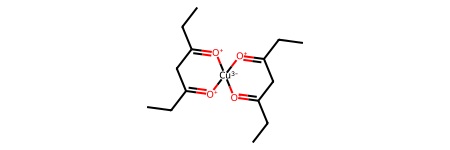

In [4]:
# Load the dataset.
path = '.'
dataset = MoleculeNet('MoleculeNet', "HIV")

# Split the dataset into train, valid, and test set.
# # Random split.
# train_indices, valid_indices, test_indices = RandomSplit(dataset)
# train_dataset = dataset[train_indices]
# valid_dataset = dataset[valid_indices]
# test_dataset = dataset[test_indices]

# Scaffold split.
train_indices, valid_indices, test_indices = ScaffoldSplit(dataset)
train_dataset = dataset[train_indices]
valid_dataset = dataset[valid_indices]
test_dataset = dataset[test_indices]

# Create data loaders.
test_loader = DataLoader(test_dataset, batch_size=128)
valid_loader = DataLoader(valid_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)

print("Dataset type: ", type(dataset))
print("Dataset features: ", dataset.num_features)
print("Dataset target: ", dataset.num_classes)
print("Dataset length: ", dataset.len)
print("Dataset splits: train, valid, test: ", len(train_dataset), len(valid_dataset), len(test_dataset))
print("Dataset sample: ", dataset[0])
print("Sample  nodes: ", dataset[0].num_nodes)
print("Sample  edges: ", dataset[0].num_edges)
# count atom types
atom_types = set()
for data in dataset:
    # check smiles
    molecule = Chem.MolFromSmiles(data["smiles"])
    for atom in molecule.GetAtoms():
        atom_types.add(atom.GetSymbol())
print("Atom types: ", atom_types)
print("Number of atom types: ", len(atom_types))

molecule = Chem.MolFromSmiles(dataset[0]["smiles"])
molecule

## Visualizing the data

We define some utility functions for visualizing the molecules and draw a random molecule.

In [5]:
from mendeleev import element

# Create a dictionary that maps atomic numbers to atom types.
atom_numbers_to_types = {element(i).atomic_number: i for i in atom_types}

print(atom_numbers_to_types)

{44: 'Ru', 83: 'Bi', 19: 'K', 77: 'Ir', 33: 'As', 11: 'Na', 28: 'Ni', 1: 'H', 26: 'Fe', 80: 'Hg', 64: 'Gd', 8: 'O', 81: 'Tl', 7: 'N', 55: 'Cs', 42: 'Mo', 67: 'Ho', 40: 'Zr', 79: 'Au', 6: 'C', 12: 'Mg', 30: 'Zn', 15: 'P', 17: 'Cl', 14: 'Si', 13: 'Al', 23: 'V', 50: 'Sn', 9: 'F', 46: 'Pd', 52: 'Te', 74: 'W', 75: 'Re', 92: 'U', 32: 'Ge', 16: 'S', 45: 'Rh', 47: 'Ag', 29: 'Cu', 27: 'Co', 22: 'Ti', 24: 'Cr', 31: 'Ga', 20: 'Ca', 65: 'Tb', 25: 'Mn', 35: 'Br', 53: 'I', 89: 'Ac', 78: 'Pt', 34: 'Se', 51: 'Sb', 82: 'Pb', 3: 'Li', 5: 'B'}


In [6]:
import networkx as nx
import numpy as np
from torch_geometric.utils import to_networkx

def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')

    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()


def to_molecule(data):

    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = atom_numbers_to_types[data['x'][0]]
        del data['x']
    return g


## Sample visualization

We sample a single molecule from train_dataset and visualize it

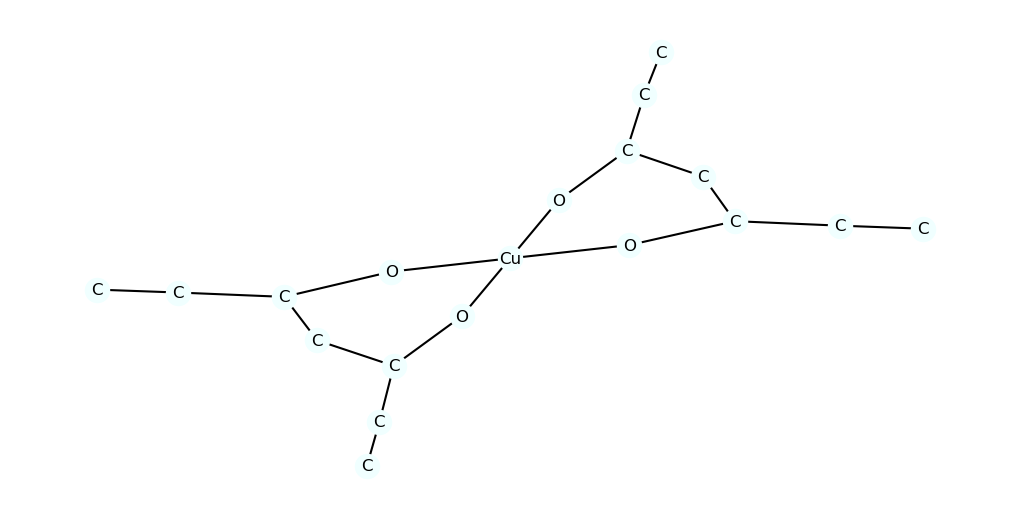

In [7]:
import random

data = dataset[0]
# print(data)
# print(data.x)
# print(data.y)
# count atom number from data["smiles"]
# molecule = Chem.MolFromSmiles(data["smiles"])
# get atom number
# atom_num = molecule.GetNumAtoms()
# print("Atom number: ", atom_num)

mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol)

## Training the model

In the next section, we train a GNN model with 5 convolution layers. We use GraphConv which supports `edge_weight` as a parameter. Many convolution layers in Pytorch Geometric supoort this argument.

### Define the model

In [8]:
config = {
    'model': 'GCN_HIV_1',
    'epochs': 200,
    'init_lr': 1e-3,
}

In [9]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

from torch_geometric.nn import GraphConv, global_add_pool

class GCN(torch.nn.Module):
    def __init__(self, embedding_size=64):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index, edge_weight=None):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index, edge_weight)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index, edge_weight)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index, edge_weight)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index, edge_weight)
        hidden = F.tanh(hidden)

        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index),
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))


GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


### Define train and test functions

In [10]:
from sklearn.metrics import roc_auc_score

loss_fn = torch.nn.BCEWithLogitsLoss() # BCEWithLogitsLoss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=config['init_lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.7, patience=5, threshold=1e-5,
                                                       min_lr=1e-10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(model, train_loader, optimizer, loss_fn):
    # Enumerate over the data
    losses = 0
    for batch in train_loader:
        batch.to(device)
        # Reset gradients
        optimizer.zero_grad()
        
        # Passing the node features and the connection info
        pred = model(batch.x.float(), batch.edge_index, batch.batch)
        
        # Calculating the loss and gradients
        loss = loss_fn(pred, batch.y)
        loss.backward()
        
        # Update using the gradients
        optimizer.step()
        losses += loss
    return losses / len(train_loader) 

# ROC AUC metric function
def calc_roc_auc(predictions, targets):
    predictions_tensor = torch.tensor(predictions)  # Convert to tensor
    targets_tensor = torch.tensor(targets)  # Convert to tensor
    predictions_tensor = torch.sigmoid(predictions_tensor)  # Apply sigmoid
    return roc_auc_score(targets_tensor, predictions_tensor)

# Test function updated to compute ROC-AUC score
def test(model, test_loader, loss_fn):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():  # Ensure no gradients are being calculated
        for batch in test_loader:
            batch.to(device)
            pred = model(batch.x.float(), batch.edge_index, batch.batch)
            predictions.extend(pred.cpu().numpy())  # Append predictions
            targets.extend(batch.y.cpu().numpy())  # Append true labels
    return calc_roc_auc(predictions, targets)


### Training


In [11]:
import gc
gc.collect()

261166

#### Classification task

In [12]:
print("Start training...")
train_losses = []
valid_losses = []
roc_auc_scores = []
best_roc_auc = 0

for epoch in range(1, config['epochs'] + 1):
    loss = train(model, train_loader, optimizer, loss_fn)
    train_losses.append(loss.item())  # Record the training loss

    # Evaluate on the validation set
    roc_auc = test(model, valid_loader, loss_fn)
    roc_auc_scores.append(roc_auc)

    scheduler.step(roc_auc)  # Adjust learning rate based on roc_auc

    # Print epoch info
    if epoch % 5 == 0:
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch} | Train Loss {loss.item()} | Valid ROC-AUC {roc_auc} | LR {lr}")

    # Save model if it achieves the best ROC-AUC score so far
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        torch.save(model.state_dict(), f"{checkpoints}/model_{config['model']}.pth")


# Convert losses and ROC-AUC scores for plotting
valid_roc_auc_scores = [float(score) for score in roc_auc_scores]

Start training...
Epoch 5 | Train Loss 0.14391039311885834 | Valid ROC-AUC 0.668096210753385 | LR 0.001
Epoch 10 | Train Loss 0.13981501758098602 | Valid ROC-AUC 0.6700815057425399 | LR 0.001
Epoch 15 | Train Loss 0.1347876638174057 | Valid ROC-AUC 0.6854542078376681 | LR 0.0007
Epoch 20 | Train Loss 0.13073958456516266 | Valid ROC-AUC 0.7042562354066002 | LR 0.0007
Epoch 25 | Train Loss 0.1269846260547638 | Valid ROC-AUC 0.7109627791759348 | LR 0.00049
Epoch 30 | Train Loss 0.12459711730480194 | Valid ROC-AUC 0.7139120781001221 | LR 0.00049
Epoch 35 | Train Loss 0.12169062346220016 | Valid ROC-AUC 0.7113618135916652 | LR 0.000343
Epoch 40 | Train Loss 0.11993449926376343 | Valid ROC-AUC 0.7101686611802727 | LR 0.000343
Epoch 45 | Train Loss 0.11831139028072357 | Valid ROC-AUC 0.7147397782000783 | LR 0.00024009999999999998
Epoch 50 | Train Loss 0.11665179580450058 | Valid ROC-AUC 0.7154726582408508 | LR 0.00024009999999999998
Epoch 55 | Train Loss 0.1155129224061966 | Valid ROC-AUC 0.7

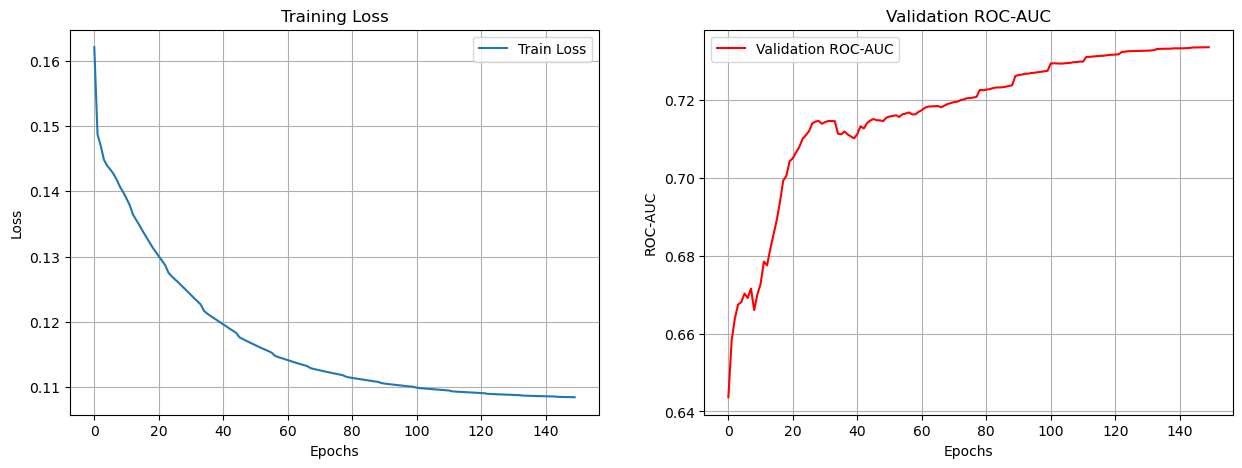

In [13]:
# Plot the Train loss and Validation ROC-AUC using axes
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_losses, label='Train Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(valid_roc_auc_scores, label='Validation ROC-AUC', color='red')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('ROC-AUC')
ax[1].set_title('Validation ROC-AUC')
ax[1].grid(True)
ax[1].legend()
plt.show()

In [19]:
import pickle
# Save the loss of the model
import pickle
with open(f"{checkpoints}/losses_" + config['model'] + ".pkl", "wb") as f:
    pickle.dump({"train": train_losses, "valid": valid_losses}, f)

# See the loss
with open(f"{checkpoints}/losses_" + config['model'] + ".pkl", "rb") as f:
    losses = pickle.load(f)
    print(losses)
    
print("The minimum loss is: ", min(losses["valid"]))

# Save the ROC-AUC scores of the model
with open(f"{checkpoints}/roc_auc_" + config['model'] + ".pkl", "wb") as f:
    pickle.dump(roc_auc_scores, f)
    
# Load the ROC-AUC scores
with open(f"{checkpoints}/roc_auc_" + config['model'] + ".pkl", "rb") as f:
    roc_auc_scores = pickle.load(f)
    print(roc_auc_scores)
    
print("The best ROC-AUC score is: ", max(roc_auc_scores))

[0.6248021065160149, 0.6288072586759276, 0.6393577734843111, 0.6609943994717407, 0.6697905712212738, 0.6793285887810088, 0.6867062861242226, 0.6928350738177341, 0.6985627756446314, 0.7001703799717935, 0.7045790636438488, 0.7088695411153774, 0.7121752386542428, 0.7163116404574987, 0.7199303806239657, 0.7221697767125633, 0.7278485656288979, 0.7328425737973538, 0.7367768022369504, 0.739890924209445, 0.7431876543813739, 0.7467273186757646, 0.7490441602060864, 0.756578378863101, 0.757969135953435, 0.7600022826024928, 0.760824019499947, 0.7620174945176779, 0.7635598816307564, 0.766063407436393, 0.7669259050926491, 0.768509868179706, 0.7694245396072295, 0.7698566036505337, 0.7774919089893776, 0.7790310352417521, 0.7794712514368168, 0.7802946187646229, 0.7806908133401811, 0.7814571156056641, 0.7828804813030398, 0.7837853701484507, 0.7827370034320559, 0.7833076540552878, 0.7832130890948666, 0.785644060749835, 0.7856538433319474, 0.7863467762315863, 0.7869125355637621, 0.7859196034793385, 0.7875

## Explaining the predictions

### Captum
Now we look at two popular attribution methods. First, we calculate the gradient of the output with respect to the edge weights $w_{e_i}$. Edge weights are initially one for all edges.
For the saliency method, we use the absolute value of the gradient as the attribution value for each edge:

$$
Attribution_{e_i} = |\frac{\partial F(x)}{\partial w_{e_i}}|
$$

Where $x$ is the input and $F(x)$ is the output of the GNN model on input $x$.

For Integrated Gradients method, we interpolate between the current input and a baseline input where the weight of all edges is zero and accumulate the gradient values for each edge:

$$
Attribution_{e_i} = \int_{\alpha =0}^1 \frac{\partial F(x_{\alpha)}}{\partial w_{e_i}} d\alpha
$$

Where $x_{\alpha}$ is the same as the original input graph but the weight of all edges is set to $\alpha$. Integrated Gradients complete formulation is more complicated but since our initial edge weights are equal to one and the baseline is zero, it can be simplified to the formulation above. You can read more about this method [here](https://arxiv.org/abs/1703.01365). Of course, this can not be calculated directly and is approximated by a discrete sum.

We use the [captum](https://captum.ai/) library for calculating the attribution values. We define the `model_forward` function which calculates the `batch` argument assuming that we are only explaining a single graph at a time.


In [22]:
# Read the best model
model.load_state_dict(torch.load(f"{checkpoints}/model_" + config['model'] + ".pth"))

model

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)

In [23]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x.float(), data.edge_index, batch, edge_mask)
    return out

def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

Finally we take a random sample from the test dataset and run the explanation methods. For a simpler visualization, we make the graph undirected and merge the explanations of each edge in both directions.

It is known that NO2 substructure makes the molecules mutagenic in many cases and you can verify this by the model explanations.

Mutagenic molecules have label 0 in this dataset and we only sample from those molecules but you can change the code and see the explanations for the other class as well.

In this visualization, edge colors and thickness represent the importance. You can also see the numeric value by passing `draw_edge_labels` to `draw_molecule` function.

As you can see Integrated Gradients tend to create more accurate explanations.

In [55]:
# Select a molecule with label 1 in training set for explanation
rank_of_1 = 3
i = 0
for data in dataset:
    if data.y.item() == 1:
        i += 1
        if i-1 == rank_of_1:
            trial_in_train = data
            break
        
trial_in_train

Data(x=[21, 9], edge_index=[2, 44], edge_attr=[44, 3], smiles='Oc1ccc(Cl)cc1C(c1cc(Cl)ccc1O)C(Cl)(Cl)Cl', y=[1, 1])

Data(x=[21, 9], edge_index=[2, 44], edge_attr=[44, 3], smiles='Oc1ccc(Cl)cc1C(c1cc(Cl)ccc1O)C(Cl)(Cl)Cl', y=[1, 1])
tensor([[1.]])


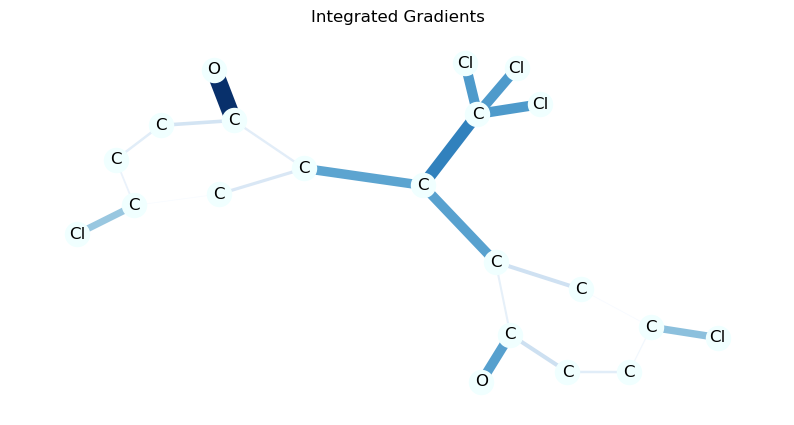

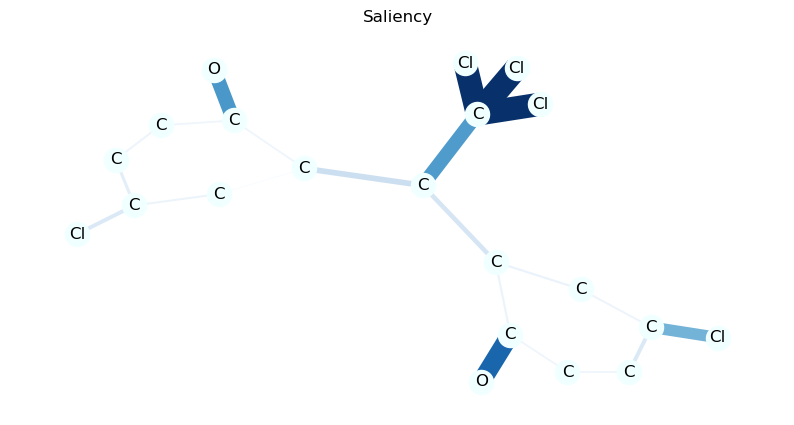

In [56]:
import random
from collections import defaultdict

# Aggregate edge directions for visualization.
def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict


print(trial_in_train)
print(trial_in_train.y)
mol = to_molecule(trial_in_train)

# Explain the prediction.
for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, trial_in_train, target=0)
    edge_mask_dict = aggregate_edge_directions(edge_mask, trial_in_train)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)

Data(x=[21, 9], edge_index=[2, 44], edge_attr=[44, 3], smiles='Oc1ccc(Cl)cc1C(c1cc(Cl)ccc1O)C(Cl)(Cl)Cl', y=[1, 1])
Original molecule


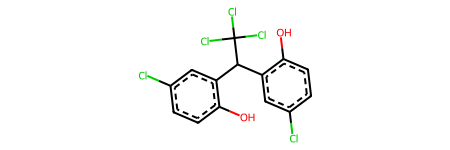

--------------------------------------------------
Explanation for Integrated Gradients


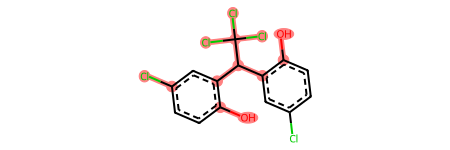

--------------------------------------------------
Explanation for Saliency


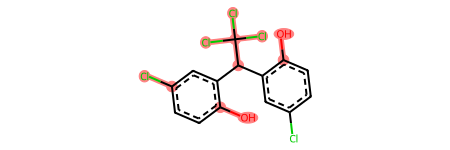

--------------------------------------------------


In [57]:
# visualize the explanation using rdKit
# add an important edge to the molecule: Draw.MolToImage(mols[0], size=(450, 150)) Draw.MolToImage(mols[0], kekulize=False, size=(450, 150), highlightAtoms=[2], highlightBonds=[0])
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole

def atom_attribution_visualize(smiles, atom_attribution, cmap_name='RdBu',):
    mol = Chem.MolFromSmiles(smiles)
    cmap = cm.get_cmap(cmap_name, 10)
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    highlight_atom_colors = {}
    atomrads = {}

    for i in range(mol.GetNumAtoms()):
        highlight_atom_colors[i] = [plt_colors.to_rgba(float(atom_attribution[i]))]
        atomrads[i] = 0.2
    rdDepictor.Compute2DCoords(mol)

    # now draw the molecule, with highlights:
    drawer = rdMolDraw2D.MolDraw2DCairo(400, 400)
    dos = drawer.drawOptions()
    dos.useBWAtomPalette()
    drawer.DrawMoleculeWithHighlights(mol, smiles, highlight_atom_colors, {}, atomrads, {})
    drawer.FinishDrawing()
    png = drawer.GetDrawingText()
    drawer.WriteDrawingText('{}_atom.png'.format(smiles))
    return png

def draw_molecule_rdkit(mol, edge_mask_dict, threshold=0.5):
    # highlight the important edges with a threshold
    highlightBonds = []
    highlightAtoms = []
    for (u, v), val in edge_mask_dict.items():
        if val > threshold:
            bond = mol.GetBondBetweenAtoms(u, v)
            highlightBonds.append(bond.GetIdx())
            highlightAtoms.append(u)
            highlightAtoms.append(v)

    img = Draw.MolToImage(mol, kekulize=False, size=(450, 150), highlightAtoms=highlightAtoms, highlightBonds=highlightBonds)
    return img

print(trial_in_train)
molecule = Chem.MolFromSmiles(trial_in_train["smiles"])
img = draw_molecule_rdkit(molecule, {})
print("Original molecule")
display(img)
print('-'*50)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, trial_in_train, target=0)
    edge_mask_dict = aggregate_edge_directions(edge_mask, trial_in_train)
    print(f"Explanation for {title}")
    img = draw_molecule_rdkit(molecule, edge_mask_dict)
    display(img)
    print('-'*50)

### PGExplainer

In [39]:
del model
del gnn_trained_model

In [40]:
# Read the best model
model = GCN()
model.load_state_dict(torch.load(f"{checkpoints}/model_" + config['model'] + ".pth"))

model

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)

In [41]:
# Initialize the parameters for PGExplainer
import copy
from torch_geometric.explain import Explainer, PGExplainer

gnn_trained_model = copy.deepcopy(model)
config_pg = {
    'epochs': 20,
    'lr': 1e-4,
}

Epoch 10 | Training...
Loss: 0.2666897177696228
Epoch 20 | Training...
Loss: 0.2653089463710785


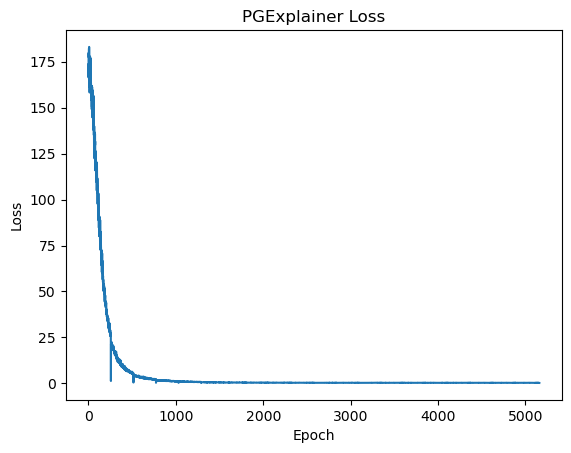

In [42]:
pgexplainer = Explainer(
    model=gnn_trained_model,
    algorithm=PGExplainer(epochs=config_pg['epochs'], lr=config_pg['lr']),
    explanation_type='phenomenon',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='raw',
    ),
    # Include only the top 10 most important edges:
    threshold_config=dict(threshold_type='topk', value=10),
)

pg_loss = []
for epoch in range(config_pg['epochs']):
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch + 1} | Training...")
    for batch in train_loader:
        loss = pgexplainer.algorithm.train(
            epoch, model, batch.x.float(), batch.edge_index, target=batch.y, batch_index=batch.batch)
        pg_loss.append(loss)
    if (epoch+1) % 10 == 0:
        print(f"Loss: {loss}")

plt.plot(pg_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PGExplainer Loss')
plt.show()

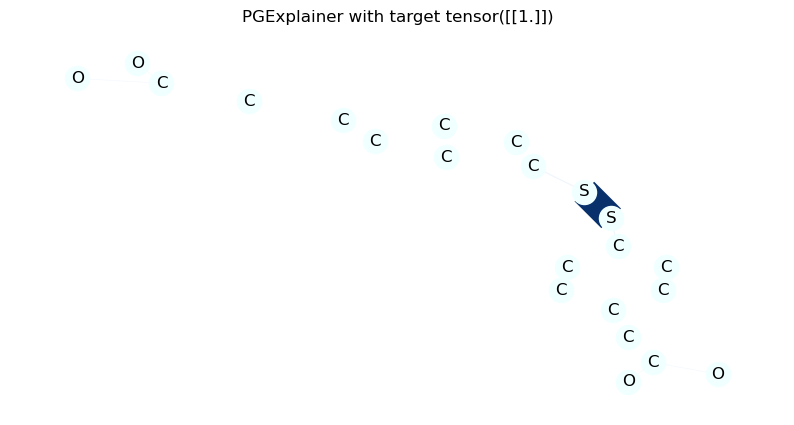

Edge mask:  defaultdict(<class 'float'>, {(0, 1): 0.04491911083459854, (1, 2): 0.03441532701253891, (1, 3): 0.0, (3, 4): 0.0, (4, 5): 0.0, (4, 21): 0.0, (5, 6): 0.0, (6, 7): 0.0, (7, 8): 0.08496471494436264, (7, 20): 0.0, (8, 9): 2.0, (9, 10): 0.08496471494436264, (10, 11): 0.0, (10, 19): 0.0, (11, 12): 0.0, (12, 13): 0.0, (13, 14): 0.0, (13, 18): 0.0, (14, 15): 0.0, (15, 16): 0.04491893947124481, (15, 17): 0.03441532701253891, (18, 19): 0.0, (20, 21): 0.0})


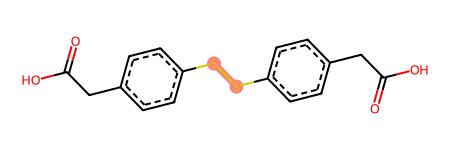

In [43]:
# Generate the explanation for a particular graph:
explanation = pgexplainer(trial_in_train.x.float(), trial_in_train.edge_index, batch_index=trial_in_train.batch, target=trial_in_train.y)
# print(explanation.edge_mask)
# visualize the explanation
# convert the edge mask to a list
# normalize the edge mask
edge_mask_ = explanation.edge_mask
edge_mask_ = edge_mask_.numpy()
edge_mask_ = (edge_mask_ - edge_mask_.min()) / (edge_mask_.max() - edge_mask_.min())
edge_mask_ = edge_mask_.tolist()
edge_mask_dict = aggregate_edge_directions(edge_mask_, trial_in_train)
plt.figure(figsize=(10, 5))
plt.title(f'PGExplainer with target {trial_in_train.y}')
draw_molecule(mol, edge_mask_dict)

print("Edge mask: ", edge_mask_dict)

# visualize the explanation using rdKit
molecule = Chem.MolFromSmiles(trial_in_train["smiles"])
img = draw_molecule_rdkit(molecule, edge_mask_dict)
display(img)

### GNNExplainer

In [58]:
# Try GNNExplainer
from torch_geometric.explain import GNNExplainer

gnnexplainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100),
    explanation_type='phenomenon',
    edge_mask_type='object',
    node_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    ),
    # Include only the top 10 most important edges:
    threshold_config=dict(threshold_type='topk', value=10),
)

# gnn_loss = []
# for epoch in range(100):
#     for batch in train_loader:
#         loss = gnnexplainer.algorithm.train(
#             epoch, model, batch.x.float(), batch.edge_index, target=batch.y, batch_index=batch.batch)
#         gnn_loss.append(loss)

# plt.plot(gnn_loss)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('GNNExplainer Loss')
# plt.show()

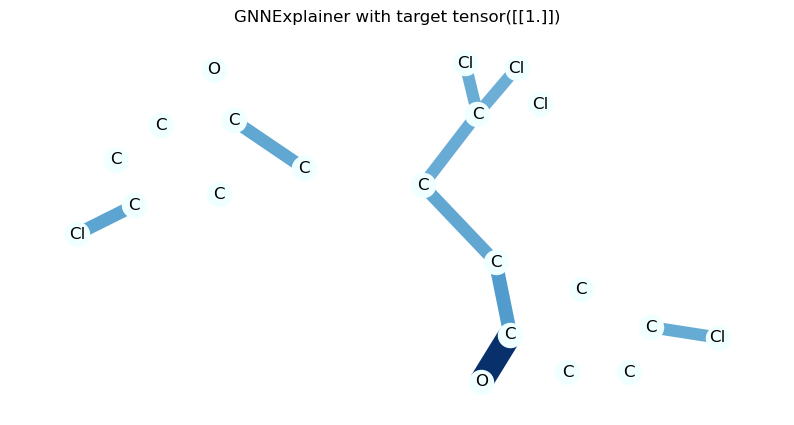

Edge mask:  defaultdict(<class 'float'>, {(0, 1): 1.7183039784431458, (1, 2): 0.0, (1, 7): 1.0, (2, 3): 0.0, (3, 4): 0.0, (4, 5): 0.8810306787490845, (4, 6): 0.0, (6, 7): 0.0, (7, 8): 0.9086073637008667, (8, 9): 0.0, (8, 17): 0.8737045526504517, (9, 10): 0.0, (9, 15): 0.9153730869293213, (10, 11): 0.0, (11, 12): 0.9281370639801025, (11, 13): 0.0, (13, 14): 0.0, (14, 15): 0.0, (15, 16): 0.0, (17, 18): 0.0, (17, 19): 0.868222177028656, (17, 20): 0.8584758043289185})


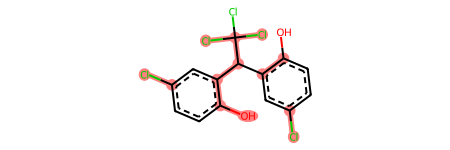

In [59]:
# visualize the explanation
# convert the edge mask to a list
# normalize the edge mask
explanation = gnnexplainer(trial_in_train.x.float(), trial_in_train.edge_index, batch_index=trial_in_train.batch, target=trial_in_train.y)
edge_mask_ = explanation.edge_mask
edge_mask_ = edge_mask_.numpy()
edge_mask_ = (edge_mask_ - edge_mask_.min()) / (edge_mask_.max() - edge_mask_.min())
edge_mask_ = edge_mask_.tolist()
edge_mask_dict = aggregate_edge_directions(edge_mask_, trial_in_train)
plt.figure(figsize=(10, 5))
plt.title(f'GNNExplainer with target {trial_in_train.y}')
draw_molecule(mol, edge_mask_dict)

print("Edge mask: ", edge_mask_dict)

# visualize the explanation using rdKit
molecule = Chem.MolFromSmiles(trial_in_train["smiles"])
img = draw_molecule_rdkit(molecule, edge_mask_dict)
display(img)
